# Pre-processing

### Import des modules

In [505]:
import torch
import pandas as pd

### Importation de la matrice binaire PLM gènes et la matrice log_ratio

In [506]:
PLM_genes = pd.read_csv('./data/matricePLM_genes.txt',sep='\t')
logratio = pd.read_csv('./data/LOG_RATIO_GEM2NET_UNIQLINK', sep='\t', index_col=0)

In [507]:
PLM_genes.head(2)

,WMCAATAATTRW_-317,TGTAAAGT_-280,CCAATGT_-275,GGATA_-263,TAACAAA_-261,HDTTAACAGAAWW_-260,AWTTAAWT_-239,RTTTTTR_-229,TATCCA_-226,GRWAAW_-212,...,SAGATCYRR_295,DYCACCGACAHH_312,GTGGWWHG_319,AGATCCAA_326,HYRGATCYRD_334,ATGTCGGYRR_344,YAGATCTR_353,CTGACY_367,ACNGCT_426,AGCAGC_444
AT5G09440,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
AT3G29320,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [508]:
logratio.head(2)

,1101,1104,29,30,1977,1973,1980,1976,1978,1974,...,1563,796,797,799,800,798,801,1296,1677,1672
AT3G32130,-0.0063,-0.0319,-0.0535,0.0539,-0.0541,0.1612,0.1375,0.0855,-0.0129,-0.0980,...,-0.0381,0.0754,-0.0046,0.0124,0.0528,-0.1200,0.0840,0.0561,-0.0201,0.0658
AT5G53730,0.0247,0.0287,0.0691,0.3603,1.0438,0.2848,-0.1228,-0.1286,0.8058,0.3493,...,-0.2150,2.0255,-0.5948,0.4510,-0.4049,0.2374,1.2723,-0.1189,-0.3150,1.1916


### Filtre pour ne garder que les gènes communs

Calcul d'un index commun puis on filtre les deux matrices grâce à cet index.

In [509]:
index_commun = PLM_genes.index.intersection(logratio.index) # index commun par intersection

# Filtre sur les deux DataFrames pour ne garder que les lignes avec les index communs
source = PLM_genes.loc[index_commun]
cible = logratio.loc[index_commun]

In [510]:
source.shape[0] - cible.shape[0] # Vérification de même nombre de lignes, doit renvoyer 0

0

### Gestion des valeurs manquantes

In [511]:
source.isnull().sum().sum() # Nombre de valeurs manquantes dans le dataframe (2 sum() car 2 dimensions)

0

In [512]:
cible.isnull().sum().sum() # Nombre de valeurs manquantes dans le dataframe

310

In [513]:
cible = cible.fillna(0) # Remplissage des valeurs manquantes par 0 (étape critique)

In [514]:
cible.isnull().sum().sum() # Vérification plus de valeur manquante

0

In [515]:
# Conversion en tenseurs
X = torch.tensor(source.values, dtype=torch.bool) # Conversion en booléens
y = torch.tensor(cible.values, dtype=torch.float32) # dtype peut changer selon le problème (classification/régression)

# Création de l'espace de représentation des PLM

L'objectif est de trouver une représentation vectorielle pertinente des PLM par apprentissage de représentations, afin d'en tirer de l'information.\
De cette façon, on considère les gènes comme une phrase et les PLM comme les mots qui composent les phrases, l'espace de représentation étant le dictionnaire qui contient la signification des mots (PLM).\
On s'attend par exemple à avoir une représentation vectorielle nulle pour des PLM qui n'interviennent pas dans la régulation génétique en cas de stress.

Pour se faire on construit un espace latent (embedding) de dimensions 178 (le nombre de PLM identifiés chez A.thaliana par la méthode PLM detect).

La stratégie consiste à construire un réseau de neuronnes qui en entrée prend une aggrégation (étape critique) des vecteurs de l'espace latent des PLM présents pour chaque gène et de prédire en sortie la valeur d'expression de ce gène pour les 387 stress (vecteur de taille 387).
On utilise une fonction de coût pour un problème de régression (exemple MSE), suivie d'une rétropogation par descente de gradient qui met à jour à la fois le réseau de neuronnes et l'espace de représentation des PLM (étape critique, problème que les 2 soient mis à jours en même temps de la même façon ou au contraire corrélation directe ?) (Dans le 2ème cas, potentiellement une bonne méthode d'évaluation de la qualité de l'embedding est de tester la performance de prédiction du réseau de neuronnes).

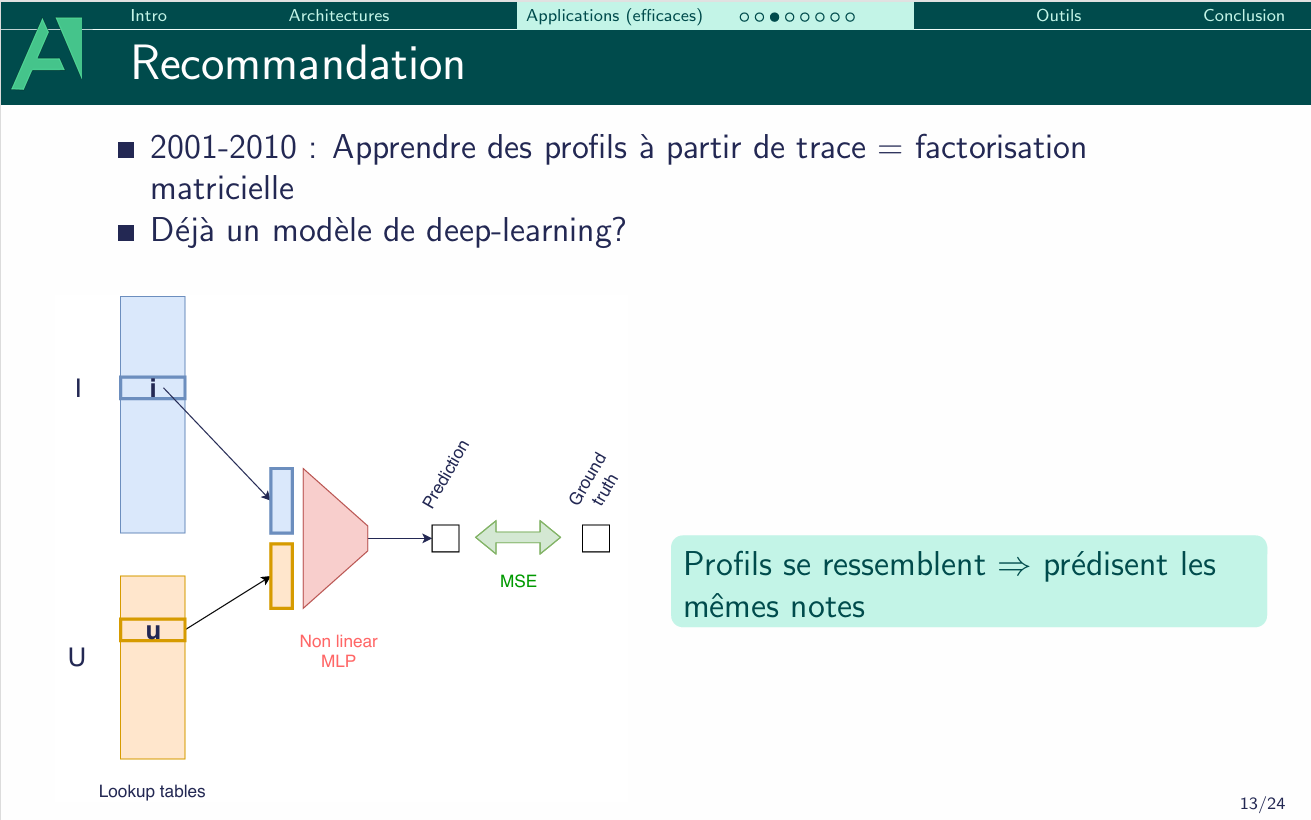

In [544]:
latent_size = 20 # Choix arbitraire à tester expérimentalement
nb_PLM = 178

embPLM = torch.nn.Embedding(nb_PLM, latent_size) # Initialisation aléatoire de l'espace de représentation

In [545]:
print("PLM n°5", embPLM(torch.tensor(5)))

PLM n°5 tensor([ 0.5026, -0.2383, -0.0462, -0.1010, -0.1807, -0.1620, -1.8296, -0.3892,
        -2.1480, -0.8010,  1.5747, -1.3564,  0.8506, -0.4508, -0.7621,  0.1548,
         0.2822, -1.4576,  3.4485, -1.1112], grad_fn=<EmbeddingBackward0>)


### Extraction des PLM pour chaque observation

In [548]:
# Récupérer les indices des 1 dans chaque ligne
indices = [row.nonzero(as_tuple=True)[0] for row in X]

# Appliquer l'embedding sur les indices sélectionnés
selected_embeddings = [embPLM(row_idx) for row_idx in indices]

Selected_embeddings est à ce stade une liste de 10956 (nombre de gènes) tensors à 2 dimensions de taille 5 à 53 (nombre de PLM par gène), 10 (taille de l'espace latent)

In [549]:
print(type(selected_embeddings), type(selected_embeddings[0]), type(selected_embeddings[0][0]))
print(len(selected_embeddings), len(selected_embeddings[0]), len(selected_embeddings[0][0]))

<class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>
10956 53 20


Problème d'uniformité de la deuxième dimension (nombre de PLM par gène) pour l'entrée dans le réseau de neuronnes.

Deux solutions :
* Faire du padding pour compléter jusqu'à 53 avec des listes de 10 zéros.
* Aggréger les vecteurs d'embedding en un seul par moyenne, attention pooling...

In [550]:
# Solution 1

# Convertir en tenseur PyTorch (optionnel)
# Padding des vecteurs de représentation des PLM à 53 (gène avec le plus de PLM) pour obtenir une forme uniforme
selected_embeddings = torch.nn.utils.rnn.pad_sequence(selected_embeddings, batch_first=True)

In [551]:
print(selected_embeddings.size())
print("Embeddings sélectionnés :\n", selected_embeddings)

torch.Size([10956, 53, 20])
Embeddings sélectionnés :
 tensor([[[ 0.6758,  1.0136, -1.1651,  ...,  0.6865, -1.8142, -0.1253],
         [-0.4367, -0.0382,  0.7549,  ...,  0.1881,  0.3581, -0.1643],
         [ 0.7227, -0.2687,  0.3135,  ..., -2.5184, -1.3284,  1.1334],
         ...,
         [ 1.2699,  0.7044, -2.8326,  ...,  0.6759, -0.5493,  0.9779],
         [-1.0056,  0.5095,  0.7700,  ..., -0.5465,  0.9509,  0.8203],
         [-0.2079, -1.1196,  0.4429,  ...,  1.1816, -2.0999,  0.3276]],

        [[-0.5041, -0.2976,  0.4993,  ..., -0.7289,  0.3841,  0.0491],
         [ 1.3606,  1.1714,  0.4021,  ...,  0.2900, -0.3442, -0.3260],
         [ 1.4291, -1.4757,  0.1044,  ..., -1.5128,  0.2473,  0.4244],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.8036,  2.1718, -0.8426,  ...,  0.3881,  1.4413, 

In [552]:
# Solution 2

# Agrégation de tout les vecteurs de PLM pour chaque gène
import torch.nn.functional as F

def attention_pooling(x):
    """
    Applique un pooling par attention sur la deuxième dimension de x.
    x : Tensor de forme (batch_size, seq_len, feature_dim)
    Retourne : Tensor de forme (batch_size, feature_dim)
    """
    # Initialisation d'un vecteur de scores aléatoire (peut être appris dans un modèle)
    attn_weights = torch.nn.Parameter(torch.randn(x.shape[2]))  # (feature_dim,)

    # Calcul des scores d'attention (projection sur une seule dimension)
    scores = torch.tanh(torch.matmul(x, attn_weights))  # (batch_size, seq_len)

    # Application du softmax pour obtenir des poids normalisés
    attn_weights = F.softmax(scores, dim=1).unsqueeze(-1)  # (batch_size, seq_len, 1)

    # Calcul de la représentation agrégée
    pooled_output = torch.sum(x * attn_weights, dim=1)  # (batch_size, feature_dim)

    return pooled_output

# L'agrégation par attention nécéssite d'apprendre les poids pour l'attention et on manque de données pour ça (d'après Antoine et je suis dac avec lui) 
# Donc par défaut on s'oriente sur une aggrégation par moyenne.

def avg_pooling(x):
    """
    Applique un global pooling par calcul de moyenne sur la deuxième dimension de x.
    x : Tensor de forme (batch_size, seq_len, feature_dim)
    Retourne : Tensor de forme (batch_size, feature_dim)
    """
    return x.mean(dim=1)

In [553]:
#output = attention_pooling(selected_embeddings)
Xagrege = avg_pooling(selected_embeddings).detach() # Format d'entrée dans le réseau de neuronnes

In [554]:
print(Xagrege.shape)  # Doit être de dimension (batch_size, feature_dim)

torch.Size([10956, 20])


L'agrégation étant une étape critique, il est important de regarder ce qu'elle renvoie.

In [555]:
print(Xagrege) # A regarder avant et surtout après l'apprentissage

tensor([[ 0.0730, -0.0040,  0.1176,  ...,  0.2020, -0.0989, -0.0228],
        [ 0.2217, -0.0482,  0.0616,  ..., -0.1248, -0.1176, -0.0431],
        [ 0.0209,  0.0282,  0.1696,  ...,  0.0788,  0.1281, -0.2620],
        ...,
        [-0.0324, -0.0171,  0.0323,  ..., -0.0018, -0.0144,  0.0226],
        [-0.0062,  0.0287, -0.0075,  ...,  0.0026, -0.0163,  0.0131],
        [ 0.0062,  0.0253,  0.0290,  ...,  0.0019,  0.0278,  0.0330]])


In [556]:
print(embPLM.parameters)

<bound method Module.parameters of Embedding(178, 20)>


In [557]:
moy_vec_agrege = Xagrege.mean(dim=1)

In [558]:
print(moy_vec_agrege.var())

tensor(8.5055e-05)


### Création des ensembles d'entrainement et de test

In [559]:
from torch.utils.data import random_split

# Définition des proportions
train_ratio = 0.7
test_ratio = 1 - train_ratio

# Nombre total d'exemples
total_size = Xagrege.shape[0]

# Calcul des tailles pour train et test
train_size = int(train_ratio * total_size)
test_size = total_size - train_size  # Assure que la somme fait bien total_size

# Séparation des indices aléatoirement
train_dataset, test_dataset = random_split(list(range(total_size)), [train_size, test_size])

# Création des ensembles train et test
X_train, y_train = Xagrege[train_dataset], y[train_dataset]
X_test, y_test = Xagrege[test_dataset], y[test_dataset]

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: torch.Size([7669, 20]), Test: torch.Size([3287, 20])


### Définition du réseau de neuronnes

In [560]:
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [561]:
# Définition du modèle
class GeneExpressionPredictor(nn.Module):
    def __init__(self, latent_size, output_dim):
        super(GeneExpressionPredictor, self).__init__()
        self.predictor = nn.Sequential(
            nn.Linear(latent_size, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(512, output_dim)
        )
    
    def forward(self, z):
        return self.predictor(z)

In [562]:
# Modèle principal
class PLMLearningModel(nn.Module):
    def __init__(self, embedding, output_dim):
        super(PLMLearningModel, self).__init__()
        self.embedding = embedding
        self.predictor = GeneExpressionPredictor(latent_size, output_dim)
    
    def forward(self, x):
        z = self.embedding(x).mean(dim=1)  # Calcul de Xagrege dans le modèle
        y_pred = self.predictor(z)
        return y_pred, z

In [563]:
# Initialisation du modèle
output_dim = 387 # Dimension de la réponse d'expression génétique. Nombre de stress pour lesquels l'expression génétique a été testé
model = PLMLearningModel(embPLM, output_dim)  # Passer l'embedding et non Xagrege (je précise car j'ai fait l'erreur)
criterion = nn.MSELoss() # Fonction de coût MSE cohérente avec un régresseur à valeurs dans R
optimizer = optim.Adam(model.parameters(), lr=0.005) # Descente de gradient Adam, la plus optimisée à l'heure actuelle

In [564]:
# Entraînement
train_losses = []
test_losses = []
num_epochs = 21
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    Y_pred, _ = model(X_train.long())  # X doit être un tensor long pour l'embedding
    train_loss = criterion(Y_pred, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item()) # Stockage des valeurs de loss

    # Évaluation sur l'ensemble de test
    model.eval()  # Met le modèle en mode évaluation
    with torch.no_grad():
        Y_test_pred, _ = model(X_test.long())
        test_loss = criterion(Y_test_pred, y_test)
    test_losses.append(test_loss.item())
        
    if epoch % 5 == 0:
        print(f"Epoch {epoch}, Train Loss: {train_loss.item():.4f}, Test Loss: {test_loss.item():.4f}")

Epoch 0, Train Loss: 0.1821, Test Loss: 0.1728
Epoch 5, Train Loss: 0.1792, Test Loss: 0.1723
Epoch 10, Train Loss: 0.1791, Test Loss: 0.1723
Epoch 15, Train Loss: 0.1791, Test Loss: 0.1723
Epoch 20, Train Loss: 0.1791, Test Loss: 0.1723


In [565]:
print(f"Test Loss (MSE) : {test_loss.item():.4f}")

mae = torch.mean(torch.abs(Y_test_pred - y_test))
print(f"Test MAE : {mae.item():.4f}")

from sklearn.metrics import r2_score
r2 = r2_score(y_test.cpu().numpy(), Y_test_pred.cpu().numpy())
print(f"Test R² Score : {r2:.4f}")

Test Loss (MSE) : 0.1723
Test MAE : 0.2479
Test R² Score : -0.0008


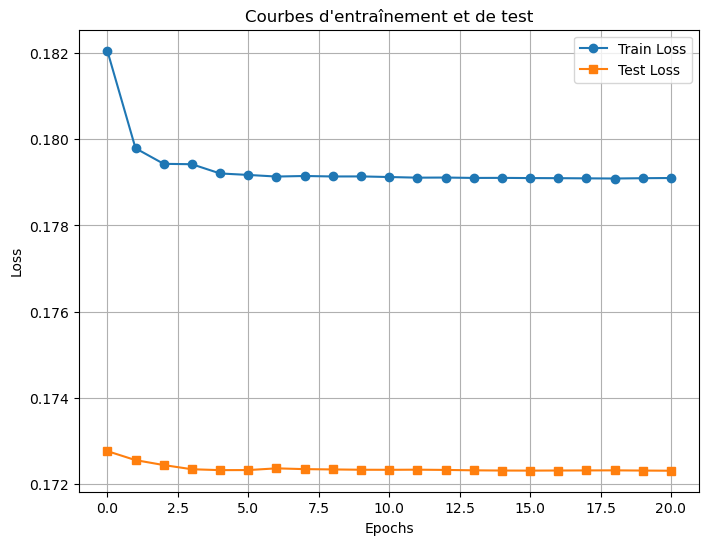

In [566]:
# Affichage des courbes d'entrainement et de test
plt.figure(figsize=(8, 6))
plt.plot(range(num_epochs), train_losses, label="Train Loss", marker='o')
plt.plot(range(num_epochs), test_losses, label="Test Loss", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Courbes d'entraînement et de test")
plt.legend()
plt.grid()
plt.show()

Peu de changements avec un réseau de neuronnes plus complexe.

# Analyse de l'espace latent de PLM après apprentissage.

In [578]:
# Récupération des embeddings appris
embeddings = model.embedding.weight.detach().cpu().numpy() # Sous format numpy

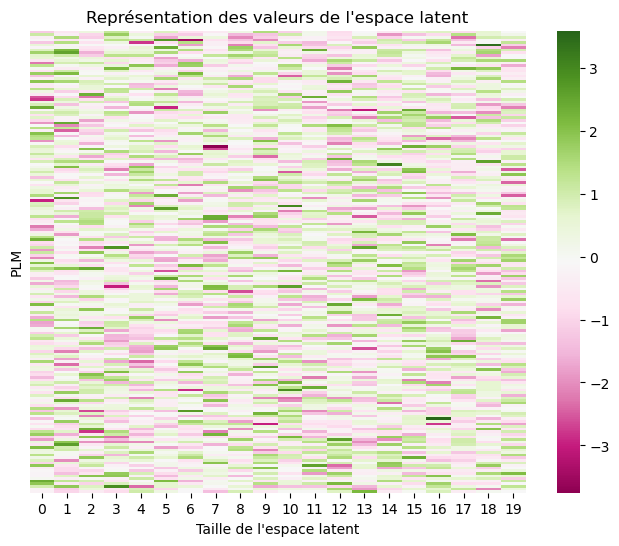

In [579]:
plt.figure(figsize=(8, 6))
sns.heatmap(embeddings, cmap="PiYG", xticklabels=True, yticklabels=False)
plt.title("Représentation des valeurs de l'espace latent")
plt.xlabel("Taille de l'espace latent")
plt.ylabel("PLM")
plt.show()

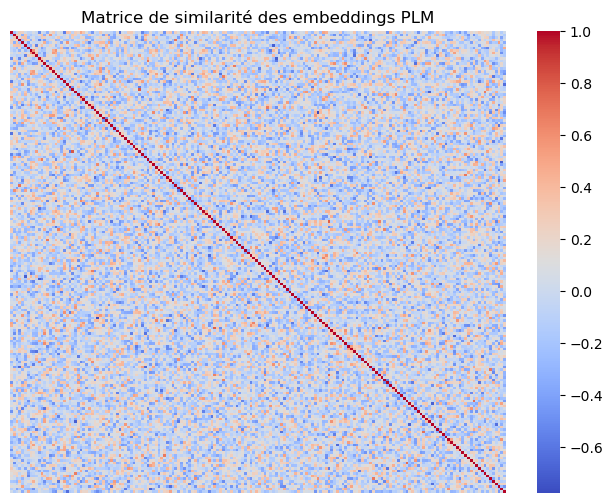

In [580]:
import seaborn as sns
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Matrice de similarité entre les PLM de l'embedding

# Calcul des distances cosinus. Les deux méthodes sont équivalentes mais à priori la deuxième est plus robuste mais boite noire.
cosine_distances = np.dot(embeddings, embeddings.T) / (np.linalg.norm(embeddings, axis=1)[:, None] * np.linalg.norm(embeddings, axis=1))
cosine_sim = cosine_similarity(embeddings)

# Affichage
plt.figure(figsize=(8, 6))
sns.heatmap(cosine_sim, cmap="coolwarm", xticklabels=False, yticklabels=False)
plt.title("Matrice de similarité des embeddings PLM")
plt.show()

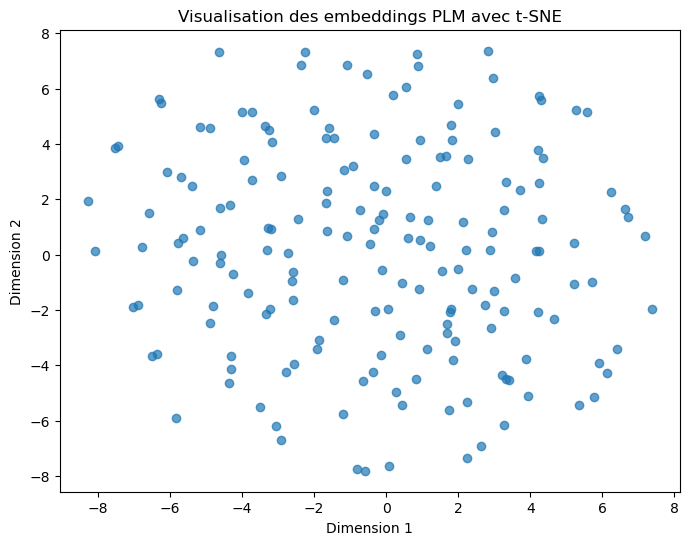

In [581]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Récupération des embeddings appris
embeddings = model.embedding.weight.detach().cpu().numpy()

# Réduction à 2 dimensions avec t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.7)
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Visualisation des embeddings PLM avec t-SNE")
plt.show()

On observe quelques groupes de points (2 à 4) superposés et isolés notamment sur les bords

In [618]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test de clusturing avec un modèle de k-means pour différentes valeurs de k
# Initialisation k-means++ optimisée

def kmeans_silhouette_score(data, kmin, kmax):

    silhouette_avg = []
    
    for k in range(kmin, kmax+1):
        kmeans = KMeans(n_clusters=k, init='k-means++', n_init=10).fit(data)
        
        labels = kmeans.labels_
        
        # Calcul du silouhette score moyen (de chaque cluster)
        silhouette_avg.append(silhouette_score(data, labels))
        
        print(f"Silhouette Score {k} clusters : {silhouette_avg[k-2]}")
    
    return(np.argmax(silhouette_avg)+2, max(silhouette_avg)) # nombre de cluster, valeurs de silouhette score global

Pour essayer de déterminer le nombre de cluster k le plus pertinent, je décide de faire tourner plusieurs fois (30 + 100) le k-means avec toutes les valeurs possibles de k et je retiens la valeurs de k avec le silhouette score le plus élevé.\
Le résultat est dans la matrice **comptage_k_cluster_max_silhouette_score**.

In [624]:
# Attention!!! cellule très longue car 100 fois 177 clustering k-means !
#for i in range(100):
#    max_silhouette_cluster.append(kmeans_silhouette_score(embeddings, 2, 177))

Silhouette Score 2 clusters : 0.05410240590572357
Silhouette Score 3 clusters : 0.04313702508807182
Silhouette Score 4 clusters : 0.04754950851202011
Silhouette Score 5 clusters : 0.04312631115317345
Silhouette Score 6 clusters : 0.04192686453461647
Silhouette Score 7 clusters : 0.042393576353788376
Silhouette Score 8 clusters : 0.04825698211789131
Silhouette Score 9 clusters : 0.04406292364001274
Silhouette Score 10 clusters : 0.047314826399087906
Silhouette Score 11 clusters : 0.04612380638718605
Silhouette Score 12 clusters : 0.04444617033004761
Silhouette Score 13 clusters : 0.043211665004491806
Silhouette Score 14 clusters : 0.04511749744415283
Silhouette Score 15 clusters : 0.03926751762628555
Silhouette Score 16 clusters : 0.04417354613542557
Silhouette Score 17 clusters : 0.03815079480409622
Silhouette Score 18 clusters : 0.042971618473529816
Silhouette Score 19 clusters : 0.04240984469652176
Silhouette Score 20 clusters : 0.04194377735257149
Silhouette Score 21 clusters : 0.04

In [628]:
print(f"Taille : {len(max_silhouette_cluster)} Valeurs : {max_silhouette_cluster}")

Taille : 130 Valeurs : [(86, 0.05556719), (52, 0.05588988), (2, 0.055101972), (78, 0.057740618), (2, 0.053842705), (2, 0.057129458), (67, 0.05686865), (65, 0.056956217), (3, 0.054952476), (38, 0.058102157), (73, 0.055634122), (69, 0.059452903), (75, 0.056664728), (2, 0.053202584), (2, 0.056365695), (2, 0.05341926), (70, 0.060415365), (67, 0.05693575), (62, 0.061508976), (2, 0.05661452), (2, 0.05655353), (65, 0.05517505), (2, 0.054011576), (71, 0.057068944), (2, 0.054682057), (76, 0.058208734), (68, 0.06029078), (47, 0.057921752), (76, 0.05520322), (72, 0.05880012), (2, 0.054102406), (78, 0.055859342), (49, 0.057785336), (2, 0.057032198), (2, 0.054996356), (74, 0.054713808), (2, 0.054949038), (49, 0.057846684), (92, 0.05534986), (44, 0.05667254), (2, 0.054397583), (2, 0.056802906), (46, 0.05421434), (2, 0.05662753), (69, 0.058877468), (34, 0.056503747), (51, 0.05473659), (2, 0.053646784), (81, 0.057616115), (83, 0.06342572), (89, 0.054897264), (2, 0.053518284), (68, 0.05966091), (2, 0.0

In [664]:
max_silhouette_cluster = np.array(max_silhouette_cluster) # On convertit en matrice numpy

In [665]:
unique_max_silhouette_cluster = np.unique(max_silhouette_cluster[:, 0]) # Nombre de cluster unique maximum enregistrés

In [666]:
comptage_k_cluster_max_silhouette_score = []
for k in unique_max_silhouette_cluster :
    comptage_k_cluster_max_silhouette_score.append([int(k), list(max_silhouette_cluster[:, 0]).count(k)])

In [667]:
comptage_k_cluster_max_silhouette_score # [nombre de cluster, nombre d'occurence]

[[2, 49],
 [3, 2],
 [8, 1],
 [29, 1],
 [30, 1],
 [32, 1],
 [34, 1],
 [35, 1],
 [38, 2],
 [41, 1],
 [43, 1],
 [44, 1],
 [45, 1],
 [46, 3],
 [47, 1],
 [49, 4],
 [50, 1],
 [51, 2],
 [52, 2],
 [54, 1],
 [55, 1],
 [56, 1],
 [57, 1],
 [58, 1],
 [61, 3],
 [62, 4],
 [63, 3],
 [65, 3],
 [66, 2],
 [67, 4],
 [68, 4],
 [69, 2],
 [70, 2],
 [71, 1],
 [72, 3],
 [73, 1],
 [74, 1],
 [75, 1],
 [76, 2],
 [78, 2],
 [79, 1],
 [81, 2],
 [82, 1],
 [83, 1],
 [86, 1],
 [89, 1],
 [90, 2],
 [92, 1],
 [112, 1]]

Le clutering à 2 clusters est souvent la meilleur option (ce qui n'est pas trop une bonne nouvelle), mais certaines valeurs de k semblent intéressantes comme 49, 62, 67, 68.